# Linear diffusion HW

Same imports from the main file 

In [ ]:
# imports
import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim, xlim
import matplotlib.pyplot as plt
import copy

from landlab.plot.imshow import imshow_grid
from landlab import RasterModelGrid 
from landlab.components import LinearDiffuser
from landlab.components import TaylorNonLinearDiffuser
from landlab.components import FlowAccumulator

## 1. 

From your experience with the linear diffusion model, you now know that if diffusivity is fixed, then a hillslope becomes steeper if the uplift/erosion rate is increased or the diffusivity is decreased. 

Run a few model cases to illustrate the same behavior holds at steady state using the nonlinear diffusion model. Describe the model sensitivity to erosion rate and diffusivity using plots and text.

In [38]:
mg = RasterModelGrid((41, 5), 5.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# open upper and lower boundary condition, closed on the sides
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

now comes the parameters to be set

In [ ]:
D = 0.01
uplift_rate = 0.0001
Sc = 0.5 # critical slope value, units of m/m
nonlin_diffuse = TaylorNonLinearDiffuser(
    mg, linear_diffusivity=D, slope_crit=Sc, dynamic_dt=True)

lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)
runtime = 1000000 
dt = 0.5 * mg.dx * mg.dx / D
nt = int(runtime // dt)
time_counter = 0
uplift_per_step = uplift_rate * dt
ys = np.arange(mg.number_of_node_rows * mg.dx - mg.dx)

steady state topography calculations of the linear diffusser as in class

In [40]:
# location of divide or ridge crest -> middle of grid
divide_loc = (mg.number_of_node_rows * mg.dx - mg.dx) / 2
# half-width of the ridge
half_width = (mg.number_of_node_rows * mg.dx - mg.dx) / 2
# analytical solution for elevation under linear diffusion at steady state
zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

a little aux plot function to make things more readable and compact

In [37]:
def short_plot(elev_rast, **kwargs):
    """
    It plots the analytical solution stored in ys and zs.
    The input is a landlab raster grid model.

    **kwargs include:
    - title: string
        Title of the chart
    - percent: bool
        Misleadingly, if passed anything it will show the
        50% and 75% of the analytical solution. Don't pass an
        argument if you don't want it to show.
    - legend_loc: string
        A string argument to position the legend. See matplotlib
        legend() for documentation
    - show_analitical: bool
        Show the analitical solution of the linear diffuser
    """
    plot(ys_grid, elev_rast[:, 2], "r-", label="current model topography")
    if "show_analitical" in kwargs:
        if kwargs["show_analitical"]:
            plot(ys, zs, "k--", label="analytical solution")
    if "title" in kwargs:
        title(kwargs["title"])
    xlabel("horizontal distance (m)")
    ylabel("vertical distance (m)")
    if "percent" in kwargs:
        plot(ys, zs * 0.75, "b--", label="75% of analytical solution")
        plot(ys, zs * 0.5, "k--", label="50% of analytical solution")
    if "legend_loc" in kwargs:
        legend(loc=kwargs["legend_loc"])
    else:
        legend()
    show()


def short_subplot(elev_rast1, elev_rast2, **kwargs):
    """
    It plots the analytical solution stored in ys and zs.
    The input is a landlab raster grid model.

    **kwargs include:
    - title: string
        Title of the chart
    - legend_loc: string
        A string argument to position the legend. See matplotlib
        legend() for documentation
    - label1: string
        legend label 1
    - label2: string
        legend label 2  
    - show_analitical: bool
        Show the analitical solution of the linear diffuser
    """
    fig, axs = plt.subplots(2, sharex=True)
    label_1 = "half time solution"
    label_2 = "current solution"
    if "label1" in kwargs:
        label_1=kwargs["label1"]
    if "label2" in kwargs:
        label_1=kwargs["label2"]
    axs[0].plot(ys_grid, elev_rast1[:, 2], "b-", label=label_1)
    axs[1].plot(ys_grid, elev_rast1[:, 2], "r-", label=label_2)
    if "show_analitical" in kwargs:
        if kwargs["show_analitical"]:
            axs[0].plot(ys, zs, "k--", label="analytical solution")
            axs[1].plot(ys, zs, "k--", label="analytical solution")
    if "title" in kwargs:
        plt.suptitle(kwargs["title"])
    axs[1].set(xlabel="horizontal distance (m)")
    axs[0].set(ylabel="elevation (m)")
    axs[1].set(ylabel="elevation (m)")
    if "legend_loc" in kwargs:
        legend(loc=kwargs["legend_loc"])
    else:
        legend()
    show()

initial topography

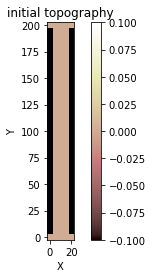

In [41]:
figure(1)
imshow_grid(mg, "topographic__elevation")
title("initial topography")
show()

Now let's plot multiple scenarios for uplift and diffusion

In [ ]:
Ds = [0.1, 0.01, 0.001]
uplift_rates = [0.00001,0.0001, 0.0005, 0.001]
Sc = 0.5
for D in Ds:
    for uplift_rate in uplift_rates:
        uplift_per_step = uplift_rate * dt 
        # plot initial topography
        figure()
        elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        short_plot(
            elev_rast, 
            title ="initial topographic cross section")
        # run non linear diff half time and final solution
        rast1 = 0
        rast2 = 0
        for i in range(nt):
            mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
            nonlin_diffuse.run_one_step(dt) # change the diffuser
            time_counter += dt
            if i == int(nt // 2):
                rast1 = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        rast2 = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        # plot both solutions
        short_subplot(
            elev_rast1=rast1,
            elev_rast2=rast2,
            title=f"topographic cross section at times {int(time_counter // 2)} and {time_counter}, with D = {D} and uplift = {uplift_rate}",
        )

*Is the nonlinear model as sensitive to changes in these paramaters as the linear model? Make sure it is clear how you are making your assesment of what it means to be more or less sensitive.* 

- The total relief is approximately $45m$.


and now we use a flow router to find the slopes

Text(0.5, 1.0, 'slope of the hillslope at time 1000000.0, with D = 0.01')

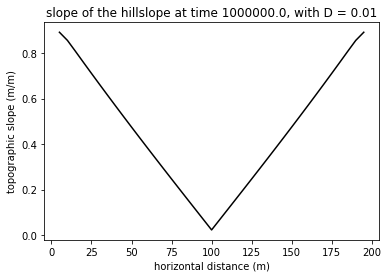

In [45]:
fr = FlowAccumulator(mg)
fr.run_one_step()
# plot slopes
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title(f"slope of the hillslope with S_c = {Sc}, and D = {D}")

## 2.

*How does changing $S_c$ impact hillslope form at steady state? Do some model runs to illustrate hillslope sensitivity to $S_c$.*

- According to the notebook the defining equations being considered are:

    $$
    q_s = -D \left( 1 + \Big( \frac{S}{S_c} \Big)^2 \right)
    $$

    $$
    \frac{dz}{dt} = U-\nabla q_s
    $$

    Notice how the $q_s$ is always positive and, in particular being a quadratic, it has smaller values the closer $\frac{S}{S_c}$ to zero but also increasingly larger values the larger $\frac{S}{S_c}$ is from one. This means that transport capacity pass the critical slope is greatly increasing forcing the slopes to go back to near/under critical slope.

    If made into a one dimensional problem then the differential equation looks like

    $$
    \frac{dz}{dt} = U-\nabla q_s = U + \frac{2D}{S_c} \frac{S}{S_c}\frac{d S}{dx}.
    $$

    The steady state solution can be solved from the separable equation

    $$
    -\frac{U S_c^2}{2D} dx  =  S dS
    $$

    compacting the constants $C= \frac{U S_c^2}{D}$ and integrating once to solve the separable equation we get

    $$
    c_1 - \frac{C}{2} x  =  \frac{S^2}{2}
    $$

    solving for $S$ and using the fact that $S=-\frac{dz}{dx}$ we now need to solve

    $$
    \frac{dz}{dx} = \pm \sqrt{c_1-Cx}
    $$

    which solves as

    $$
    z = c_2 \pm \frac{2}{3C}(c_1-Cx)^{3/2}
    $$

    or

    $$
    z = c_2 \pm \frac{2}{3}(c_1-\sqrt[3]{C}x)^{3/2}
    $$

From here we see that the topography relief increases and descreases with critical slope by roughly a factor of $\sqrt{C}$. In a similar way, using the equation $ S = \pm \sqrt{c_1-Cx} $ we see that slopes will scale roughly by a factor of $\sqrt{C}$.

Now let's see some plots to confirm this.

## 3. 
*If relief is defined as the difference between maximum and minimum elevation, do hillslopes evolved with the linear or nonlinear model have more relief? Compare hillslopes with the same $D$ value between the two models.*

-

*Discuss how the hillslope differs from the results in question 1. Discuss how the results are similar to or different from your prediction in question 2. It is OK if your intuition was wrong! If you were wrong, can you see why from the equations after a second look?*

- The new hillslope parabola has a coefficient that is a tenth of the original which maches in the graph with the model being on a scale of a tenth as well. 

- The results match my predictions, one thing that I was not expecting was the convergence being faster as the curves are closer even after considering the scale which I'm guessing has something to do with the numerical method used to solve it.

## 4.
On two hillslopes with different $S_c$, but the same erosion rate and $D$, explore the patterns of relief produced at steady state (Code Block 10). 

*How does the radius over which relief is calculated impact the patterns of relief you see across the hillslope?*
- answer here


*Does the pattern change with the different values of $S_c$? Again, this is a very unconstrained question. Explore, describe what you find using full sentences and plots.*
- answer here

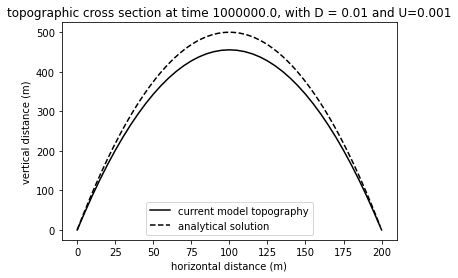

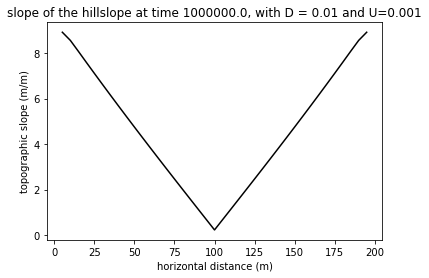

In [50]:
mg = RasterModelGrid((41, 5), 5.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

D = 0.01
uplift_rate = 0.001
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)
time_counter = 0
uplift_per_step = uplift_rate * dt
zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

for i in range(nt):
    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
    lin_diffuse.run_one_step(dt)
    time_counter += dt

figure(6)
short_plot(
    elev_rast=mg.node_vector_to_raster(mg.at_node["topographic__elevation"]),
    title=f"topographic cross section at time {time_counter}, with D = {D} and U={uplift_rate}"
)

figure(7)
fr = FlowAccumulator(mg)
fr.run_one_step()
# plot slopes
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title(f"slope of the hillslope at time {time_counter}, with D = {D} and U={uplift_rate}")
show()

*Discuss how these results differ from the results in question 1 and how the results match (or do not) your intuition. It is OK if your intuition was wrong.*

- The hillslope is 10 times larger than the original one as expected and the convergence looks about as good as in the first one. Slopes are also a magnitude of 10 larger.